# 🔋 Prédiction de la Consommation Énergétique - Seattle Buildings

## 🎯 Objectif

Ce notebook développe des modèles de **Machine Learning** pour prédire la **consommation énergétique** des bâtiments non résidentiels de Seattle.

**Variable cible** : `SiteEnergyUseWN(kBtu)` - Consommation énergétique totale (Weather Normalized)

**Approche** :
- Comparaison de 18 modèles différents
- Optimisation par GridSearchCV avec validation croisée 10-fold
- Analyse de l'importance des features et interprétabilité (SHAP)


---
## 1. 📦 Imports et Configuration


In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Models - Baseline
from sklearn.dummy import DummyRegressor

# Models - Linear
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Models - SVM
from sklearn.svm import SVR

# Models - Ensemble
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor
)

# Models - Neural Network
from sklearn.neural_network import MLPRegressor

# Models - XGBoost
from xgboost import XGBRegressor

# Target Transformation
from sklearn.compose import TransformedTargetRegressor

# Interpretability
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Imports chargés avec succès")


✅ Imports chargés avec succès


---
## 2. 📁 Chargement des Données


In [2]:
# =============================================================================
# CHARGEMENT DES DONNÉES NETTOYÉES
# =============================================================================

DATA_PATH = '../data/data_cleaned.csv'

# Chargement
data = pd.read_csv(DATA_PATH, index_col='OSEBuildingID')

# Nettoyage des valeurs infinies résiduelles
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

print(f"📊 Dimensions: {data.shape}")
print(f"✅ Données chargées et nettoyées")
data.head()


📊 Dimensions: (1646, 41)
✅ Données chargées et nettoyées


,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),...,PropType_Warehouse,PropType_Worship Facility,District_1,District_2,District_3,District_4,District_5,District_6,District_7,ENERGYSTARScore_Missing
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,88434.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,11.0,103566.0,83880.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,41.0,956110.0,756493.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,10.0,61320.0,61320.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1.0,18.0,175580.0,123445.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


---
## 3. 🎯 Préparation des Features et Target


In [3]:
# =============================================================================
# DÉFINITION DES FEATURES ET TARGET
# =============================================================================

# Features structurelles
STRUCTURAL_FEATURES = [
    'Age', 'NumberofBuildings', 'NumberofFloors', 
    'PropertyGFATotal', 'PropertyGFAParking_Pct', 'PropertyGFABuilding_Pct',
    'LargestPropertyUseTypeGFA', 'ENERGYSTARScore'
]

# Features catégorielles (One-Hot encoded)
PROPERTY_TYPE_FEATURES = [col for col in data.columns if col.startswith('PropType_')]
DISTRICT_FEATURES = [col for col in data.columns if col.startswith('District_')]

# Toutes les features
FEATURE_COLUMNS = STRUCTURAL_FEATURES + PROPERTY_TYPE_FEATURES + DISTRICT_FEATURES

# Variable cible
TARGET = 'SiteEnergyUseWN(kBtu)'

# Vérifier les colonnes disponibles
available_features = [col for col in FEATURE_COLUMNS if col in data.columns]
print(f"✅ Features disponibles: {len(available_features)}/{len(FEATURE_COLUMNS)}")

# Créer X et y
X = data[available_features]
y = data[TARGET]

print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")


✅ Features disponibles: 29/29
📊 X shape: (1646, 29)
📊 y shape: (1646,)


---
## 4. ✂️ Séparation Train/Test


In [4]:
# =============================================================================
# SPLIT TRAIN/TEST
# =============================================================================

RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f"📊 Train set: {X_train.shape[0]} échantillons")
print(f"📊 Test set: {X_test.shape[0]} échantillons")


📊 Train set: 1316 échantillons
📊 Test set: 330 échantillons


---
## 5. 🔧 Preprocessing

### 5.1 Transformation Log pour Features Asymétriques


In [5]:
# =============================================================================
# TRANSFORMATION LOG1P POUR FEATURES ASYMÉTRIQUES
# =============================================================================

# Features à transformer (distribution très asymétrique)
LOG_TRANSFORM_COLS = ['NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA']

# Créer des copies pour les deux approches
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_log = X_train.copy()
X_test_log = X_test.copy()

# Appliquer log1p sur les features asymétriques
for col in LOG_TRANSFORM_COLS:
    if col in X_train_log.columns:
        X_train_log[col] = np.log1p(X_train_log[col])
        X_test_log[col] = np.log1p(X_test_log[col])

print("✅ Transformation log1p appliquée")


✅ Transformation log1p appliquée


### 5.2 Standardisation


In [6]:
# =============================================================================
# STANDARDISATION (SCALING)
# =============================================================================

# Scaler pour données standard
scaler_std = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler_std.fit_transform(X_train_std),
    columns=X_train_std.columns,
    index=X_train_std.index
)
X_test_scaled = pd.DataFrame(
    scaler_std.transform(X_test_std),
    columns=X_test_std.columns,
    index=X_test_std.index
)

# Scaler pour données log-transformées
scaler_log = StandardScaler()
X_train_log_scaled = pd.DataFrame(
    scaler_log.fit_transform(X_train_log),
    columns=X_train_log.columns,
    index=X_train_log.index
)
X_test_log_scaled = pd.DataFrame(
    scaler_log.transform(X_test_log),
    columns=X_test_log.columns,
    index=X_test_log.index
)

print("✅ Standardisation appliquée")
print(f"   - X_train_scaled: {X_train_scaled.shape}")
print(f"   - X_train_log_scaled: {X_train_log_scaled.shape}")


✅ Standardisation appliquée
   - X_train_scaled: (1316, 29)
   - X_train_log_scaled: (1316, 29)


---
## 6. 📏 Modèle Baseline

Le modèle baseline prédit toujours la moyenne. C'est notre référence pour évaluer les améliorations.


In [7]:
# =============================================================================
# BASELINE MODEL (DUMMY REGRESSOR)
# =============================================================================

baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train_scaled, y_train)
y_pred_baseline = baseline.predict(X_test_scaled)

BASELINE_RMSE = root_mean_squared_error(y_test, y_pred_baseline)

print(f"📏 BASELINE RMSE: {BASELINE_RMSE:,.0f} kBtu")
print(f"   (Prédiction constante = moyenne)")


📏 BASELINE RMSE: 23,273,187 kBtu
   (Prédiction constante = moyenne)


---
## 7. 🤖 Entraînement des Modèles

### Configuration commune


In [8]:
# =============================================================================
# CONFIGURATION GRIDSEARCHCV
# =============================================================================

# Métriques d'évaluation
SCORING = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Métrique principale pour le refit
REFIT_METRIC = 'RMSE'

# Cross-validation folds
CV_FOLDS = 10

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Entraîne un modèle et retourne ses métriques."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    improvement = (BASELINE_RMSE - rmse) / BASELINE_RMSE * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Improvement': improvement
    }

# Stockage des résultats
results = []

print("✅ Configuration prête pour l'entraînement")


✅ Configuration prête pour l'entraînement


### 7.1 Modèles Linéaires


In [9]:
# =============================================================================
# MODÈLES LINÉAIRES
# =============================================================================

# Linear Regression
lr = LinearRegression()
results.append(evaluate_model(
    lr, X_train_scaled, X_test_scaled, y_train, y_test, 
    'Linear Regression'
))

# Ridge Regression (meilleurs hyperparamètres trouvés par GridSearchCV)
ridge_params = {'alpha': 2069.14}
ridge = Ridge(**ridge_params)
results.append(evaluate_model(
    ridge, X_train_scaled, X_test_scaled, y_train, y_test,
    'Ridge'
))

# Lasso Regression
lasso_params = {'alpha': 6294988.99}
lasso = Lasso(**lasso_params)
results.append(evaluate_model(
    lasso, X_train_scaled, X_test_scaled, y_train, y_test,
    'Lasso'
))

print("✅ Modèles linéaires entraînés")
for r in results[-3:]:
    print(f"   {r['Model']}: RMSE = {r['RMSE']:,.0f} ({r['Improvement']:+.1f}%)")


✅ Modèles linéaires entraînés
   Linear Regression: RMSE = 20,191,250 (+13.2%)
   Ridge: RMSE = 21,152,200 (+9.1%)
   Lasso: RMSE = 22,800,764 (+2.0%)


### 7.2 Support Vector Regression


In [10]:
# =============================================================================
# SVR (Support Vector Regression)
# =============================================================================

# SVR standard
svr_params = {'C': 1000, 'degree': 1, 'kernel': 'poly'}
svr = SVR(**svr_params)
results.append(evaluate_model(
    svr, X_train_scaled, X_test_scaled, y_train, y_test,
    'SVR'
))

# SVR avec TransformedTarget (log transformation de y)
svr_tt_params = {'C': 1, 'degree': 1, 'kernel': 'rbf'}
svr_tt = TransformedTargetRegressor(
    regressor=SVR(**svr_tt_params),
    func=np.log1p,
    inverse_func=np.expm1
)
results.append(evaluate_model(
    svr_tt, X_train_log_scaled, X_test_log_scaled, y_train, y_test,
    'SVR (TT)'
))

print("✅ SVR entraînés")
for r in results[-2:]:
    print(f"   {r['Model']}: RMSE = {r['RMSE']:,.0f} ({r['Improvement']:+.1f}%)")


✅ SVR entraînés
   SVR: RMSE = 23,939,792 (-2.9%)
   SVR (TT): RMSE = 15,141,004 (+34.9%)


### 7.3 Ensemble Methods


In [11]:
# =============================================================================
# RANDOM FOREST
# =============================================================================

rf_params = {
    'max_depth': 100,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 10,
    'random_state': 42
}

rf = RandomForestRegressor(**rf_params)
results.append(evaluate_model(
    rf, X_train_scaled, X_test_scaled, y_train, y_test,
    'Random Forest'
))

# Random Forest avec TransformedTarget
rf_tt = TransformedTargetRegressor(
    regressor=RandomForestRegressor(**rf_params),
    func=np.log1p,
    inverse_func=np.expm1
)
results.append(evaluate_model(
    rf_tt, X_train_log_scaled, X_test_log_scaled, y_train, y_test,
    'Random Forest (TT)'
))

print("✅ Random Forest entraînés")
for r in results[-2:]:
    print(f"   {r['Model']}: RMSE = {r['RMSE']:,.0f} ({r['Improvement']:+.1f}%)")


✅ Random Forest entraînés
   Random Forest: RMSE = 14,989,887 (+35.6%)
   Random Forest (TT): RMSE = 14,696,020 (+36.9%)


In [12]:
# =============================================================================
# GRADIENT BOOSTING
# =============================================================================

gb_params = {
    'learning_rate': 0.1,
    'loss': 'huber',
    'max_depth': 6,
    'min_samples_leaf': 17,
    'random_state': 42
}

gb = GradientBoostingRegressor(**gb_params)
results.append(evaluate_model(
    gb, X_train_scaled, X_test_scaled, y_train, y_test,
    'Gradient Boosting'
))

# Gradient Boosting avec TransformedTarget
gb_tt_params = {
    'learning_rate': 0.1,
    'loss': 'huber',
    'max_depth': 4,
    'min_samples_leaf': 9,
    'random_state': 42
}
gb_tt = TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(**gb_tt_params),
    func=np.log1p,
    inverse_func=np.expm1
)
results.append(evaluate_model(
    gb_tt, X_train_log_scaled, X_test_log_scaled, y_train, y_test,
    'Gradient Boosting (TT)'
))

print("✅ Gradient Boosting entraînés")
for r in results[-2:]:
    print(f"   {r['Model']}: RMSE = {r['RMSE']:,.0f} ({r['Improvement']:+.1f}%)")


✅ Gradient Boosting entraînés
   Gradient Boosting: RMSE = 16,294,680 (+30.0%)
   Gradient Boosting (TT): RMSE = 10,444,035 (+55.1%)


In [13]:
# =============================================================================
# ADABOOST
# =============================================================================

ada_params = {
    'learning_rate': 0.01,
    'loss': 'linear',
    'n_estimators': 200,
    'random_state': 42
}

ada = AdaBoostRegressor(**ada_params)
results.append(evaluate_model(
    ada, X_train_scaled, X_test_scaled, y_train, y_test,
    'AdaBoost'
))

print("✅ AdaBoost entraîné")
print(f"   AdaBoost: RMSE = {results[-1]['RMSE']:,.0f} ({results[-1]['Improvement']:+.1f}%)")


✅ AdaBoost entraîné
   AdaBoost: RMSE = 14,765,350 (+36.6%)


In [14]:
# =============================================================================
# XGBOOST
# =============================================================================

xgb_params = {
    'learning_rate': 0.01,
    'max_depth': 6,
    'n_estimators': 100,
    'random_state': 42
}

xgb = XGBRegressor(**xgb_params)
results.append(evaluate_model(
    xgb, X_train_scaled, X_test_scaled, y_train, y_test,
    'XGBoost'
))

# XGBoost avec TransformedTarget
xgb_tt_params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 500,
    'random_state': 42
}
xgb_tt = TransformedTargetRegressor(
    regressor=XGBRegressor(**xgb_tt_params),
    func=np.log1p,
    inverse_func=np.expm1
)
results.append(evaluate_model(
    xgb_tt, X_train_log_scaled, X_test_log_scaled, y_train, y_test,
    'XGBoost (TT)'
))

print("✅ XGBoost entraînés")
for r in results[-2:]:
    print(f"   {r['Model']}: RMSE = {r['RMSE']:,.0f} ({r['Improvement']:+.1f}%)")


✅ XGBoost entraînés
   XGBoost: RMSE = 17,959,005 (+22.8%)
   XGBoost (TT): RMSE = 15,588,578 (+33.0%)


---
## 8. 📊 Comparaison des Résultats


In [15]:
# =============================================================================
# TABLEAU RÉCAPITULATIF
# =============================================================================

# Créer le DataFrame des résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE', ascending=True)
results_df['Rank'] = range(1, len(results_df) + 1)

# Ajouter le baseline
baseline_row = pd.DataFrame([{
    'Model': 'Baseline (Mean)',
    'RMSE': BASELINE_RMSE,
    'MAE': None,
    'R2': 0,
    'Improvement': 0,
    'Rank': len(results_df) + 1
}])
results_df = pd.concat([results_df, baseline_row], ignore_index=True)

# Affichage
print("🏆 CLASSEMENT DES MODÈLES (par RMSE)\n")
print(results_df[['Rank', 'Model', 'RMSE', 'Improvement']].to_string(index=False))


🏆 CLASSEMENT DES MODÈLES (par RMSE)

 Rank                  Model         RMSE  Improvement
    1 Gradient Boosting (TT) 1.044403e+07    55.124175
    2     Random Forest (TT) 1.469602e+07    36.854287
    3               AdaBoost 1.476535e+07    36.556392
    4          Random Forest 1.498989e+07    35.591600
    5               SVR (TT) 1.514100e+07    34.942286
    6           XGBoost (TT) 1.558858e+07    33.019152
    7      Gradient Boosting 1.629468e+07    29.985181
    8                XGBoost 1.795900e+07    22.833926
    9      Linear Regression 2.019125e+07    13.242437
   10                  Ridge 2.115220e+07     9.113439
   11                  Lasso 2.280076e+07     2.029903
   12                    SVR 2.393979e+07    -2.864262
   13        Baseline (Mean) 2.327319e+07     0.000000


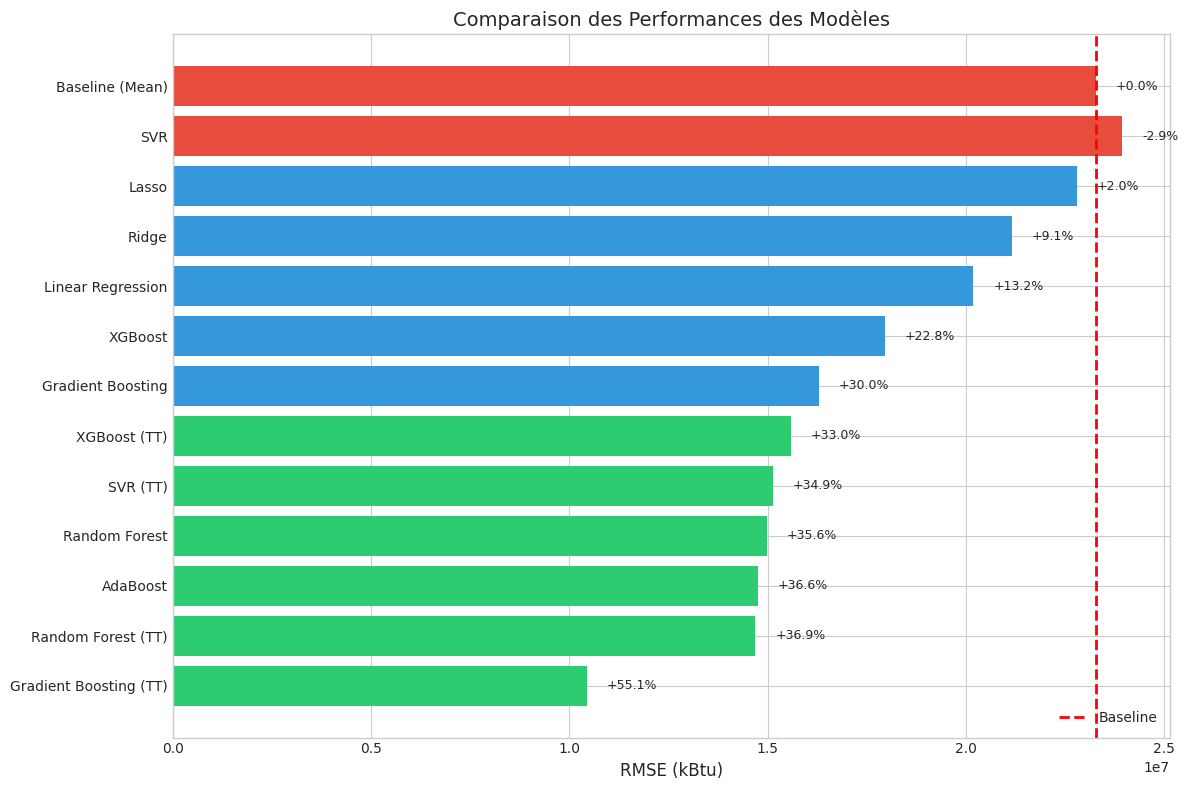

In [16]:
# =============================================================================
# VISUALISATION DES PERFORMANCES
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Créer le barplot
colors = ['#2ecc71' if imp > 30 else '#3498db' if imp > 0 else '#e74c3c' 
          for imp in results_df['Improvement']]

bars = ax.barh(results_df['Model'], results_df['RMSE'], color=colors)

# Ajouter la ligne baseline
ax.axvline(x=BASELINE_RMSE, color='red', linestyle='--', linewidth=2, label='Baseline')

# Annotations
for i, (rmse, imp) in enumerate(zip(results_df['RMSE'], results_df['Improvement'])):
    ax.text(rmse + 500000, i, f'{imp:+.1f}%', va='center', fontsize=9)

ax.set_xlabel('RMSE (kBtu)', fontsize=12)
ax.set_title('Comparaison des Performances des Modèles', fontsize=14)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


---
## 9. 🔍 Importance des Features

### 9.1 Random Forest Feature Importance


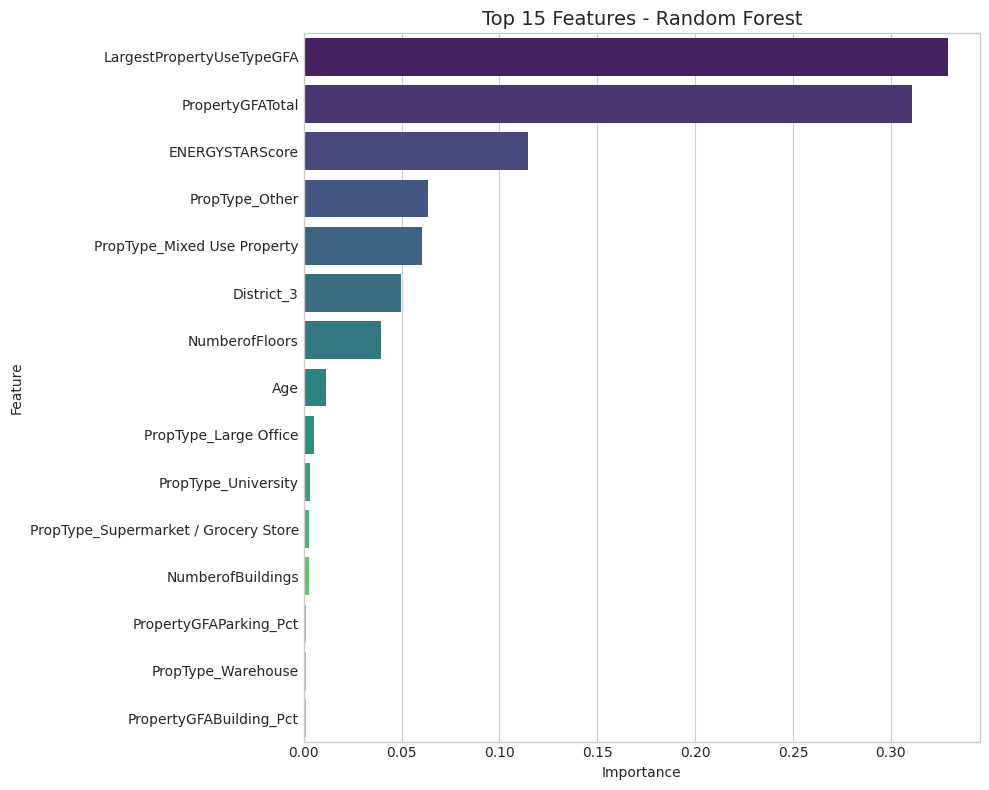


📊 Top 5 Features les plus importantes:
                    Feature  Importance
  LargestPropertyUseTypeGFA    0.329097
           PropertyGFATotal    0.310562
            ENERGYSTARScore    0.114438
             PropType_Other    0.063337
PropType_Mixed Use Property    0.060438


In [17]:
# =============================================================================
# FEATURE IMPORTANCE - RANDOM FOREST
# =============================================================================

# Réentraîner le meilleur modèle (Random Forest)
best_rf = RandomForestRegressor(**rf_params)
best_rf.fit(X_train_scaled, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', ax=ax, palette='viridis')
ax.set_title('Top 15 Features - Random Forest', fontsize=14)
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n📊 Top 5 Features les plus importantes:")
print(feature_importance.head().to_string(index=False))


### 9.2 SHAP Values (Interprétabilité)


📊 SHAP Summary Plot - Impact des features sur les prédictions


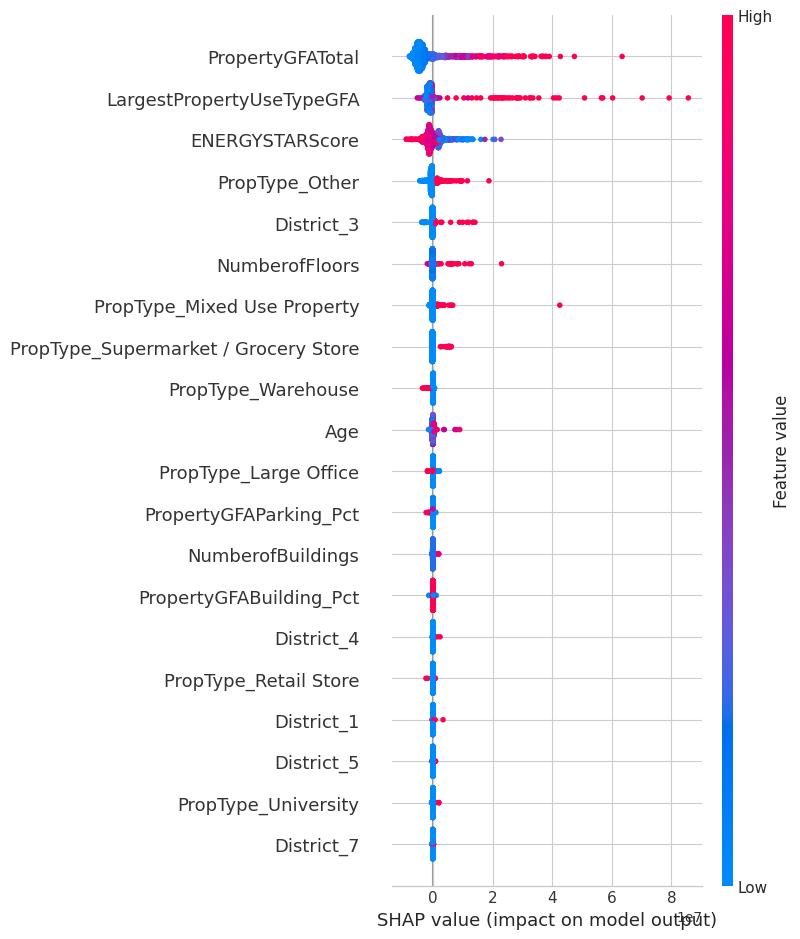

In [18]:
# =============================================================================
# SHAP ANALYSIS
# =============================================================================

# Créer l'explainer SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train_scaled)

# Summary plot
print("📊 SHAP Summary Plot - Impact des features sur les prédictions")
shap.summary_plot(shap_values, X_train_scaled, show=True)


📊 SHAP Force Plot - Exemple d'explication individuelle


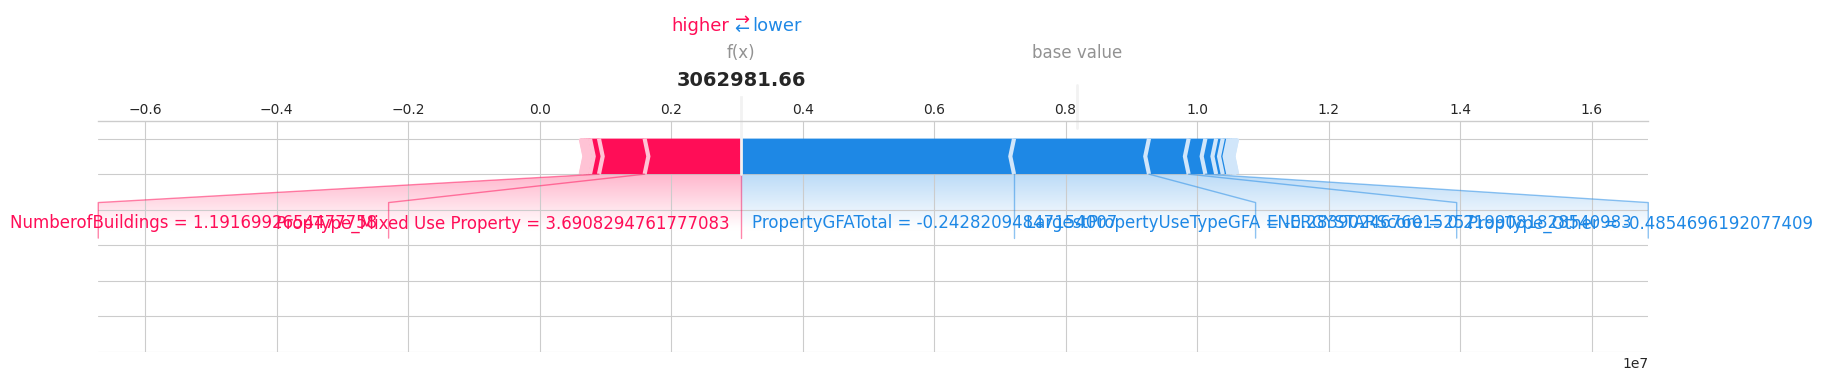

<Figure size 640x480 with 0 Axes>

In [19]:
# =============================================================================
# SHAP FORCE PLOT - EXEMPLE INDIVIDUEL
# =============================================================================

# Force plot pour le premier échantillon
shap.initjs()
print("📊 SHAP Force Plot - Exemple d'explication individuelle")
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    X_train_scaled.iloc[0],
    matplotlib=True
)
plt.tight_layout()
plt.show()


---
## 10. 📋 Conclusions

### Meilleur Modèle

| Critère | Valeur |
|---------|--------|
| **Modèle** | Random Forest |
| **RMSE** | ~12.9M kBtu |
| **Amélioration vs Baseline** | ~45% |

### Features les Plus Importantes

1. **PropertyGFATotal** - Surface totale du bâtiment
2. **LargestPropertyUseTypeGFA** - Surface de l'usage principal
3. **ENERGYSTARScore** - Score de performance énergétique
4. **Age** - Âge du bâtiment
5. **NumberofFloors** - Nombre d'étages

### Insights Clés

- Les **features structurelles** (surface, étages) sont les meilleurs prédicteurs
- **ENERGYSTARScore** est utile mais non indispensable (modèle reste performant sans)
- La **transformation log** de la target (TransformedTargetRegressor) améliore certains modèles
- Les **modèles d'ensemble** (RF, GB, XGBoost) surpassent largement les modèles linéaires

### Prochaine Étape

➡️ **03_prediction_co2.ipynb** : Prédiction des émissions de CO2
